## Results of


MODEL_1 and 3 <br>
CLASSIFIED WITH WORDS ONLY(NOT PHRASE)<br>
ngram = 2


In [1]:
from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from nltk.stem.wordnet import WordNetLemmatizer
import re
import itertools
import os.path
import json
from datetime import datetime

import pandas as pd


In [2]:
def remove_numbers(ing):
    # remove numbers from ingredients
    
    return [[re.sub("\d+", "", x) for x in y] for y in ing]

    
def remove_special_chars(ing):
    # remove certain special characters from ingredients
   
    ing = [[x.replace("-", " ") for x in y] for y in ing] 
    ing = [[x.replace("&", " ") for x in y] for y in ing] 
    ing = [[x.replace("'", " ") for x in y] for y in ing] 
    ing = [[x.replace("''", " ") for x in y] for y in ing] 
    ing = [[x.replace("%", " ") for x in y] for y in ing] 
    ing = [[x.replace("!", " ") for x in y] for y in ing] 
    ing = [[x.replace("(", " ") for x in y] for y in ing] 
    ing = [[x.replace(")", " ") for x in y] for y in ing] 
    ing = [[x.replace("/", " ") for x in y] for y in ing] 
    ing = [[x.replace("/", " ") for x in y] for y in ing] 
    ing = [[x.replace(",", " ") for x in y] for y in ing] 
    ing = [[x.replace(".", " ") for x in y] for y in ing] 
    ing = [[x.replace(u"\u2122", " ") for x in y] for y in ing] 
    ing = [[x.replace(u"\u00AE", " ") for x in y] for y in ing] 
    ing = [[x.replace(u"\u2019", " ") for x in y] for y in ing] 

    return ing
    
    
def make_lowercase(ing):
    # make all letters lowercase for all ingredients
    
    return [[x.lower() for x in y] for y in ing]
    
    
def remove_extra_whitespace(ing):
    # removes extra whitespaces
    
    return [[re.sub( '\s+', ' ', x).strip() for x in y] for y in ing] 
    
    
def stem_words(ing):
    # word stemming for ingredients
    
    lmtzr = WordNetLemmatizer()
    
    def word_by_word(strng):
        
        return " ".join(["".join(lmtzr.lemmatize(w)) for w in strng.split()])
    
    return [[word_by_word(x) for x in y] for y in ing] 
    
    
def remove_units(ing):
    # remove certain words from ingredients
    
    remove_list = ['g', 'lb', 's', 'n']
        
    def check_word(strng):
        
        s = strng.split()
        resw  = [word for word in s if word.lower() not in remove_list]
        
        return ' '.join(resw)

    return [[check_word(x) for x in y] for y in ing] 


In [3]:
### by all the words

df=pd.read_json('./train.json')
X = df['ingredients'].values
Y = df['cuisine'].values

In [4]:
X = make_lowercase(X)           # 소문자로 변환
X = remove_numbers(X)           # 숫자 제거 
X = remove_special_chars(X)     # 특수 문자제거
X = remove_extra_whitespace(X)  # 추가 공백 제거
X = remove_units(X)             # ['g', 'lb', 's', 'n'] 와 같은 단위 제거
X = stem_words(X)               # Lemmatization(원형화) nltk를 활용한 WordNetLemmatizer

In [5]:
df['ingredients_preprocessed'] = X

In [6]:
df['ingredients_as_sentence'] = df['ingredients_preprocessed'].apply(', '.join)

In [7]:
X = df['ingredients_as_sentence'].values

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(X)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2 ,random_state=2019, stratify = Y )
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31819, 76243) (7955, 76243) (31819,) (7955,)


In [10]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
        
    print("classification report:")
    print(metrics.classification_report(y_test, pred,target_names=target_names))
    
    
    #if opts.print_cm:
    #print("confusion matrix:")
    #print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


In [12]:
RANDOM_ST = 2019

target_names = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
           'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
           'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag",random_state=RANDOM_ST), "Ridge Classifier"),
        (Perceptron(max_iter=50, tol=1e-3,random_state=RANDOM_ST), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50, tol=1e-3,random_state=RANDOM_ST), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100,random_state=RANDOM_ST), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
    
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,penalty=penalty,random_state=RANDOM_ST)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,penalty="elasticnet",random_state=RANDOM_ST)))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,tol=1e-3,random_state=RANDOM_ST))),
  ('classification', LinearSVC(penalty="l2",random_state=RANDOM_ST))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=2019, solver='sag',
        tol=0.01)
train time: 4.731s
test time:  0.010s
accuracy:   0.780
dimensionality: 76243
density: 0.892659
classification report:
              precision    recall  f1-score   support

   brazilian       0.82      0.49      0.62        93
     british       0.69      0.34      0.45       161
cajun_creole       0.79      0.66      0.72       309
     chinese       0.77      0.90      0.83       535
    filipino       0.81      0.50      0.61       151
      french       0.59      0.65      0.62       529
       greek       0.81      0.69      0.74       235
      indian       0.83      0.90      0.86       601
       irish       0.73      0.36      0.48       133
     italian       0.78      0.91      0.84      1568
    jam

train time: 5.626s
test time:  0.009s
accuracy:   0.794
dimensionality: 76243
density: 0.892659
classification report:
              precision    recall  f1-score   support

   brazilian       0.83      0.56      0.67        93
     british       0.57      0.41      0.48       161
cajun_creole       0.77      0.69      0.73       309
     chinese       0.80      0.86      0.83       535
    filipino       0.73      0.60      0.66       151
      french       0.62      0.68      0.65       529
       greek       0.79      0.71      0.75       235
      indian       0.86      0.91      0.88       601
       irish       0.74      0.47      0.57       133
     italian       0.81      0.89      0.85      1568
    jamaican       0.85      0.65      0.74       105
    japanese       0.85      0.71      0.77       284
      korean       0.80      0.73      0.76       166
     mexican       0.90      0.93      0.92      1288
    moroccan       0.84      0.79      0.81       164
     russian    

/home/ncp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


train time: 4.412s
test time:  0.014s
accuracy:   0.775
dimensionality: 76243
density: 0.217562
classification report:
              precision    recall  f1-score   support

   brazilian       0.80      0.44      0.57        93
     british       0.69      0.23      0.34       161
cajun_creole       0.74      0.69      0.72       309
     chinese       0.75      0.89      0.82       535
    filipino       0.77      0.48      0.59       151
      french       0.63      0.61      0.62       529
       greek       0.81      0.68      0.74       235
      indian       0.82      0.92      0.87       601
       irish       0.81      0.32      0.46       133
     italian       0.77      0.91      0.83      1568
    jamaican       0.86      0.62      0.72       105
    japanese       0.85      0.67      0.75       284
      korean       0.82      0.70      0.75       166
     mexican       0.87      0.93      0.90      1288
    moroccan       0.83      0.76      0.80       164
     russian    

density: 1.000000
classification report:
              precision    recall  f1-score   support

   brazilian       0.72      0.54      0.62        93
     british       0.46      0.43      0.45       161
cajun_creole       0.62      0.72      0.66       309
     chinese       0.75      0.85      0.80       535
    filipino       0.72      0.54      0.62       151
      french       0.52      0.58      0.55       529
       greek       0.77      0.63      0.69       235
      indian       0.86      0.88      0.87       601
       irish       0.64      0.41      0.50       133
     italian       0.81      0.83      0.82      1568
    jamaican       0.77      0.52      0.62       105
    japanese       0.86      0.62      0.72       284
      korean       0.77      0.64      0.70       166
     mexican       0.91      0.88      0.90      1288
    moroccan       0.69      0.76      0.72       164
     russian       0.55      0.38      0.45        98
 southern_us       0.62      0.73      0

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

import xgboost as xgb

def Xgboost_():
    try:
        pipe = Pipeline([('classifier', xgb.XGBClassifier(random_state=RANDOM_ST))])
        hyperparameter_space = [{'classifier': [xgb.XGBClassifier()],
                                 'classifier__max_depth': [3, 4, 5],
                                 'classifier__n_estimators' : [350, 375, 400]}]
        grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
        grid.fit(X_train, y_train)

        cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
                   'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
                   'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

        print (classification_report(y_test, grid.predict(X_test), digits=4, target_names=cuisine))

        return print("Best parameters:\n{}\n".format(grid.best_params_), 
                     "Best score : {}\n".format(grid.best_score_),
                     "Test score : {}".format(grid.score(X_test, y_test)))
    except Exception as e:
        print(e)

In [ ]:
Xgboost_()

In [13]:
import xgboost as xgb

# xgb  <- xgboost(xgbmat, max.depth = 25, 
# eta = 0.3, nround = 200, objective = "multi:softmax", num_class = 20)
# https://www.kaggle.com/mohdatir/xgboost

results.append(benchmark(xgb.XGBClassifier(max_depth=25, n_estimators=400, random_state=RANDOM_ST)))

# objective='binary:logistic'  objective issue : 
# https://stackoverflow.com/questions/39386966/multiclass-classification-in-xgboost-python


________________________________________________________________________________
Training: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=2019, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
train time: 9072.071s
test time:  20.206s
accuracy:   0.793
classification report:
              precision    recall  f1-score   support

   brazilian       0.88      0.60      0.71        93
     british       0.66      0.39      0.49       161
cajun_creole       0.77      0.71      0.74       309
     chinese       0.79      0.86      0.82       535
    filipino       0.74      0.56      0.64       151
      french       0.62      0.65      0.64       529
       greek       0.83      0.69      0.75       235


In [36]:
results =[('RidgeClassifier', 0.7802639849151477, 4.730539083480835, 0.010100364685058594), ('Perceptron', 0.7504714016341923, 0.749875545501709, 0.012344121932983398), ('PassiveAggressiveClassifier', 0.7693274670018856, 1.4168105125427246, 0.011583328247070312), ('KNeighborsClassifier', 0.7174104336895034, 0.04632210731506348, 10.84746503829956), ('RandomForestClassifier', 0.7338780641106223, 120.3596305847168, 0.4328477382659912), ('LinearSVC', 0.7940917661847895, 5.625608444213867, 0.008724212646484375), ('SGDClassifier', 0.7751099937146448, 4.412171363830566, 0.013699769973754883), ('LinearSVC', 0.7937146448774356, 20.497478485107422, 0.007840633392333984), ('SGDClassifier', 0.7029541169076052, 8.629814863204956, 0.013385534286499023), ('SGDClassifier', 0.7565053425518542, 12.050124883651733, 0.013379096984863281), ('NearestCentroid', 0.6248900062853551, 0.06776666641235352, 0.015046834945678711), ('MultinomialNB', 0.7449402891263356, 0.1841135025024414, 0.008781671524047852), ('BernoulliNB', 0.722438717787555, 0.19157123565673828, 0.06558728218078613), ('ComplementNB', 0.7211816467630421, 0.19689583778381348, 0.008781671524047852), ('Pipeline', 0.7952231301068511, 22.48663091659546, 0.013879060745239258), ('XGBClassifier', 0.7929604022627278, 9072.071280479431, 20.20596432685852)]

In [37]:
results = sorted(results,  key=lambda x: x[1], reverse=True)

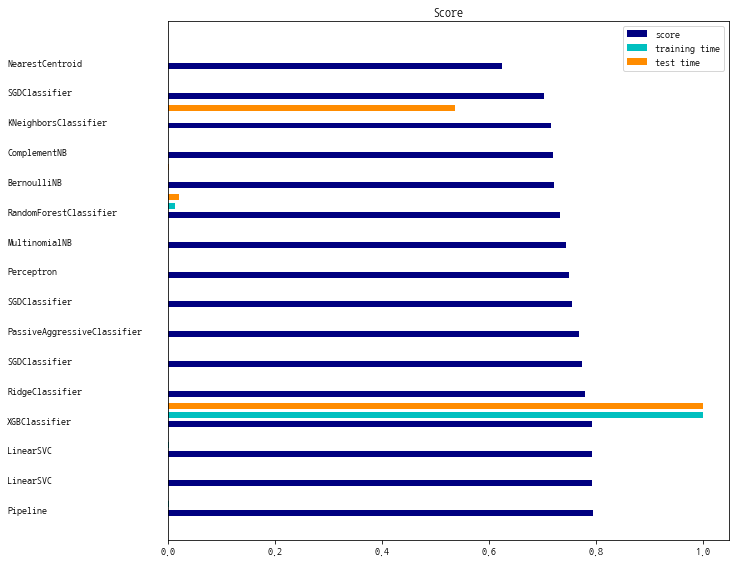

In [38]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [39]:
print(score)

[0.7952231301068511, 0.7940917661847895, 0.7937146448774356, 0.7929604022627278, 0.7802639849151477, 0.7751099937146448, 0.7693274670018856, 0.7565053425518542, 0.7504714016341923, 0.7449402891263356, 0.7338780641106223, 0.722438717787555, 0.7211816467630421, 0.7174104336895034, 0.7029541169076052, 0.6248900062853551]


In [40]:
print(np.average(score))

0.7484600879949717


In [41]:
print(max(score))

0.7952231301068511
